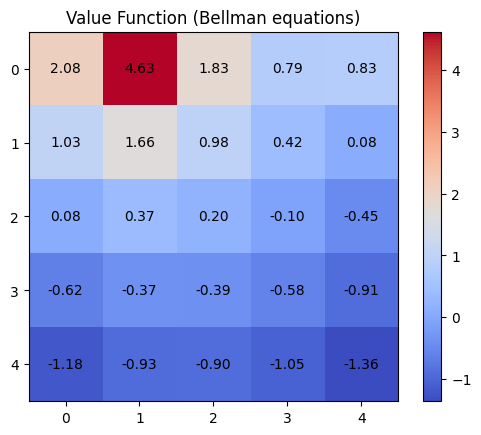

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Gridworld dimensions
grid_size = 5
n_states = grid_size * grid_size
gamma = 0.95

# Mapping actions: up, down, left, right
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
action_prob = 0.25  # uniform random policy

# Special states (row, col): index = row * grid_size + col
blue = (0, 1)
green = (0, 4)
red = (3, 2)
yellow = (4, 4)

# Convert to state index
def to_index(row, col):
    return row * grid_size + col

blue_idx = to_index(*blue)
green_idx = to_index(*green)
red_idx = to_index(*red)
yellow_idx = to_index(*yellow)

# Transition and reward model
def step(state, action):
    row, col = divmod(state, grid_size)
    new_row, new_col = row + action[0], col + action[1]

    if (row, col) == blue:
        return red_idx, 5
    elif (row, col) == green:
        # Random jump to yellow or red with 0.5 prob
        return [(red_idx, 2.5 * 0.5), (yellow_idx, 2.5 * 0.5)]
    elif 0 <= new_row < grid_size and 0 <= new_col < grid_size:
        return to_index(new_row, new_col), 0
    else:
        return state, -0.5

# -------------------------------
# 1. Solve Bellman equations directly
# -------------------------------
P = np.zeros((n_states, n_states))
R = np.zeros(n_states)

for s in range(n_states):
    r_total = 0
    for a in actions:
        result = step(s, a)
        if isinstance(result, list):
            for s_, r in result:
                P[s, s_] += action_prob * 1.0  # split prob into P
                r_total += action_prob * r
        else:
            s_, r = result
            P[s, s_] += action_prob
            r_total += action_prob * r
    R[s] = r_total

# Solve V = R + γPV => (I - γP)V = R
I = np.eye(n_states)
V_exact = np.linalg.solve(I - gamma * P, R)

# Reshape for visualization
V_exact_grid = V_exact.reshape((grid_size, grid_size))


# -------------------------------
# Visualization
# -------------------------------
def plot_values(V, title):
    fig, ax = plt.subplots()
    im = ax.imshow(V, cmap='coolwarm', interpolation='nearest')
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            ax.text(j, i, f"{V[i, j]:.2f}", ha='center', va='center', color='black')
    plt.title(title)
    plt.colorbar(im)
    plt.show()

plot_values(V_exact_grid, "Value Function (Bellman equations)")


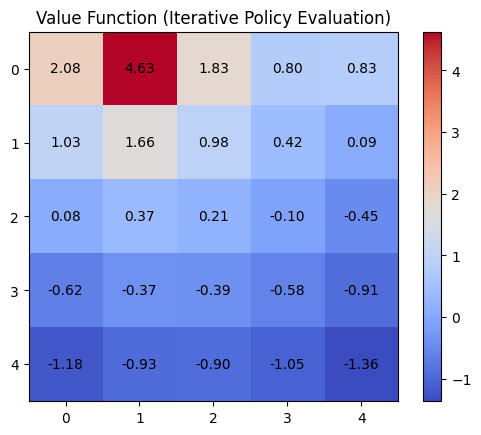

In [ ]:
# 2. Iterative Policy Evaluation
# -------------------------------
def iterative_policy_evaluation(threshold=1e-4, max_iter=1000):
    V = np.zeros(n_states)
    for i in range(max_iter):
        delta = 0
        V_new = np.zeros_like(V)
        for s in range(n_states):
            v = 0
            for a in actions:
                result = step(s, a)
                if isinstance(result, list):
                    v += action_prob * sum([r + gamma * V[s_] for s_, r in result])
                else:
                    s_, r = result
                    v += action_prob * (r + gamma * V[s_])
            V_new[s] = v
            delta = max(delta, abs(V[s] - V_new[s]))
        V = V_new
        if delta < threshold:
            break
    return V.reshape((grid_size, grid_size))

V_iterative = iterative_policy_evaluation()
# -------------------------------
# Visualization
# -------------------------------
def plot_values(V, title):
    fig, ax = plt.subplots()
    im = ax.imshow(V, cmap='coolwarm', interpolation='nearest')
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            ax.text(j, i, f"{V[i, j]:.2f}", ha='center', va='center', color='black')
    plt.title(title)
    plt.colorbar(im)
    plt.show()

plot_values(V_iterative, "Value Function (Iterative Policy Evaluation)")

🔢 Value Iteration:
Optimal Policy:
→ ↑ ← ← ↑ 
↑ ↑ ↑ ↑ ← 
↑ ↑ ↑ ↑ ↑ 
↑ ↑ ↑ ↑ ↑ 
↑ ↑ ↑ ↑ ↑ 


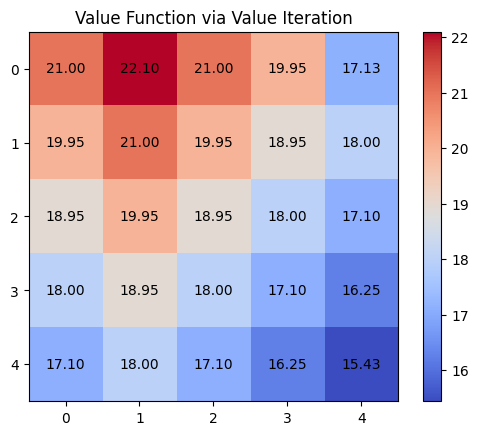

In [ ]:

def value_iteration(threshold=1e-4, max_iters=1000):
    V = np.zeros(n_states)
    policy = np.zeros(n_states, dtype=int)

    for i in range(max_iters):
        delta = 0
        for s in range(n_states):
            if s in terminal_indices:
                continue
            action_values = []
            for a in range(4):
                transitions = step(s, a)
                prob = 1 / len(transitions)
                val = sum([prob * (r + gamma * V[s_]) for s_, r in transitions])
                action_values.append(val)
            best = max(action_values)
            delta = max(delta, abs(V[s] - best))
            V[s] = best
            policy[s] = np.argmax(action_values)
        if delta < threshold:
            break
    return policy.reshape(grid_size, grid_size), V.reshape(grid_size, grid_size)

# Visualize values
def plot_values(V, title):
    fig, ax = plt.subplots()
    im = ax.imshow(V, cmap='coolwarm')
    for i in range(grid_size):
        for j in range(grid_size):
            ax.text(j, i, f"{V[i,j]:.2f}", ha='center', va='center', color='black')
    plt.title(title)
    plt.colorbar(im)
    plt.show()

# Print arrows for policy
def print_policy(policy_grid):
    print("Optimal Policy:")
    for i in range(grid_size):
        row = ""
        for j in range(grid_size):
            row += action_arrows[policy_grid[i, j]] + " "
        print(row)

# Run it
policy_vi, V_vi = value_iteration()
print("🔢 Value Iteration:")
print_policy(policy_vi)
plot_values(V_vi, "Value Function via Value Iteration")


Optimal Policy (Policy Iteration):
→ ↑ ← ← ↑ 
→ ↑ ↑ ↑ ← 
→ ↑ ↑ ↑ ↑ 
→ ↑ ↑ ↑ ↑ 
→ ↑ ↑ ↑ ↑ 


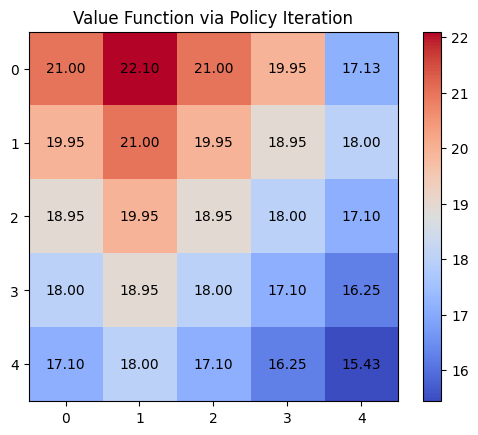

In [ ]:
# Policy Evaluation
def evaluate_policy(policy, threshold=1e-4):
    V = np.zeros(n_states)
    while True:
        delta = 0
        for s in range(n_states):
            if s in terminal_indices:
                continue
            a = policy[s]
            transitions = step(s, a)
            prob = 1 / len(transitions)
            val = sum([prob * (r + gamma * V[s_]) for s_, r in transitions])
            delta = max(delta, abs(V[s] - val))
            V[s] = val
        if delta < threshold:
            break
    return V

# Policy Iteration
def policy_iteration():
    policy = np.zeros(n_states, dtype=int)
    while True:
        V = evaluate_policy(policy)
        stable = True
        for s in range(n_states):
            if s in terminal_indices:
                continue
            old_action = policy[s]
            action_values = []
            for a in range(4):
                transitions = step(s, a)
                prob = 1 / len(transitions)
                val = sum([prob * (r + gamma * V[s_]) for s_, r in transitions])
                action_values.append(val)
            best_action = np.argmax(action_values)
            policy[s] = best_action
            if best_action != old_action:
                stable = False
        if stable:
            break
    return policy.reshape(grid_size, grid_size), V.reshape(grid_size, grid_size)

# Display functions
def print_policy(policy_grid):
    print("Optimal Policy (Policy Iteration):")
    for i in range(grid_size):
        row = ""
        for j in range(grid_size):
            row += action_arrows[policy_grid[i, j]] + " "
        print(row)

def plot_values(V, title):
    fig, ax = plt.subplots()
    im = ax.imshow(V, cmap='coolwarm')
    for i in range(grid_size):
        for j in range(grid_size):
            ax.text(j, i, f"{V[i,j]:.2f}", ha='center', va='center', color='black')
    plt.title(title)
    plt.colorbar(im)
    plt.show()

# Run
policy_pi, V_pi = policy_iteration()
print_policy(policy_pi)
plot_values(V_pi, "Value Function via Policy Iteration")


Optimal Policy (via Value Iteration + Policy Improvement):
→ ↑ ← ← ↑ 
↑ ↑ ↑ ↑ ← 
↑ ↑ ↑ ↑ ↑ 
↑ ↑ ↑ ↑ ↑ 
↑ ↑ ↑ ↑ ↑ 


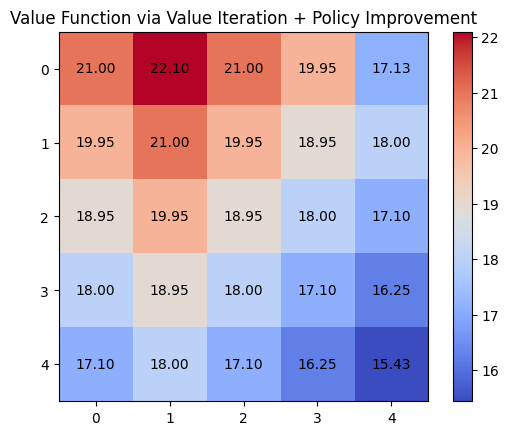

In [ ]:
# Value Iteration + Policy Improvement
def value_iteration(threshold=1e-4, max_iters=1000):
    V = np.zeros(n_states)
    policy = np.zeros(n_states, dtype=int)

    for _ in range(max_iters):
        delta = 0
        for s in range(n_states):
            if s in terminal_indices:
                continue
            action_values = []
            for a in range(4):
                transitions = step(s, a)
                prob = 1 / len(transitions)
                val = sum([prob * (r + gamma * V[s_]) for s_, r in transitions])
                action_values.append(val)
            best_action_value = max(action_values)
            best_action = np.argmax(action_values)
            delta = max(delta, abs(V[s] - best_action_value))
            V[s] = best_action_value
            policy[s] = best_action
        if delta < threshold:
            break
    return policy.reshape(grid_size, grid_size), V.reshape(grid_size, grid_size)

# Display functions
def print_policy(policy_grid):
    print("Optimal Policy (via Value Iteration + Policy Improvement):")
    for i in range(grid_size):
        row = ""
        for j in range(grid_size):
            row += action_arrows[policy_grid[i, j]] + " "
        print(row)

def plot_values(V, title):
    fig, ax = plt.subplots()
    im = ax.imshow(V, cmap='coolwarm')
    for i in range(grid_size):
        for j in range(grid_size):
            ax.text(j, i, f"{V[i,j]:.2f}", ha='center', va='center', color='black')
    plt.title(title)
    plt.colorbar(im)
    plt.show()

# Run the algorithm
policy_vi, V_vi = value_iteration()
print_policy(policy_vi)
plot_values(V_vi, "Value Function via Value Iteration + Policy Improvement")
